<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #3. Fall 2018
## <center> Decision trees for classification and regression

**In this assignment, we will find out how a decision tree works in a regression task, then will build and tune classification decision trees for identifying heart diseases.
Fill in the missing code in the cells marked "You code here" and answer the questions in the [web form](https://docs.google.com/forms/d/1hsrNFSiRsvgB27gMbXfQWpq8yzNhLZxuh_VSzRz7XhI).**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. A simple example of regression using decision trees

Let's consider the following one-dimensional regression problem. It is needed to build the function $a(x)$ to approximate original dependency $y = f(x)$ using mean-squared error $min \sum_i {(a(x_i) - f(x_i))}^2$.

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]


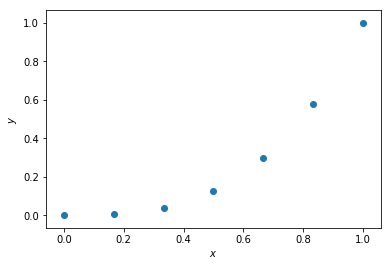

In [3]:
X = np.linspace(0, 1, 7)
print(X)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Let's make several steps to build the decision tree. Let's choose the symmetric thresholds equal to 0, 1.5 and -1.5 for partitioning. In the case of a regression task, the leaf outputs mean answer for all observations in this leaf.

Let's start from tree of depth 0 that contains all train observations. How will predictions of this tree look like for $x \in [-2, 2]$? Create the appropriate plot using a pen, paper and Python if it is needed (without using `sklearn`).

In [3]:
# You code here

Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. Let's create a similar plot for predictions of this tree.

In [4]:
# You code here

In the decision tree algorithm, the feature and the threshold for splitting are chosen according to some criterion. The commonly used criterion for regression is based on variance: $$\large Q(X, y, j, t) = D(X, y) - \dfrac{|X_l|}{|X|} D(X_l, y_l) - \dfrac{|X_r|}{|X|} D(X_r, y_r),$$
where $\large X$ and $\large y$ are a feature matrix and a target vector (correspondingly) for training instances in a current node, $\large X_l, y_l$ and $\large X_r, y_r$ are splits of samples $\large X, y$ into two parts w.r.t. $\large [x_j < t]$ (by $\large j$-th feature and threshold $\large t$), $\large |X|$, $\large |X_l|$, $\large |X_r|$ (or, the same, $\large |y|$, $\large |y_l|$, $\large |y_r|$) are sizes of appropriate samples, and $\large D(X, y)$ is variance of answers $\large y$ for all instances in $\large X$:
$$\large D(X) = \dfrac{1}{|X|} \sum_{j=1}^{|X|}(y_j – \dfrac{1}{|X|}\sum_{i = 1}^{|X|}y_i)^2$$
Here $\large y_i = y(x_i)$ is the answer for the $\large x_i$ instance. Feature index $\large j$ and threshold $\large t$ are chosen to maximize the value of criterion  $\large Q(X, y, j, t)$ for each split.

In our 1D case,  there's only one feature so $\large Q$ depends only on threshold $\large t$ and training data $\large X$ and $\large y$. Let's designate it $\large Q_{1d}(X, y, t)$ meaning that the criterion no longer depends on feature index $\large j$, i.e. in 1D case $\large j = 0$.

Create the plot of criterion $\large Q_{1d}(X, y, t)$  as a function of threshold value $t$ on the interval $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    pass
    # You code here

In [6]:
# You code here

**<font color='red'>Question 1.</font> Is the threshold value $t = 0$ optimal according to the variance criterion?**
- Yes
- No 

Then let's make splitting in each of the leaves' nodes. In the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. It gives us the tree of depth 2 with 7 nodes and 4 leaves. Create the plot of these tree predictions for $x \in [-2, 2]$.

In [78]:
# You code here
xx = np.linspace(-2, 2, 200)

def prediction(x, X, y):
    if x >= 1.5:
        return np.mean(y[X >= 1.5])
    elif x < 1.5 and x >= 0:
        return np.mean(y[(X >= 0) & (X < 1.5)])
    elif x >= -1.5 and x < 0:
        return np.mean(y[(X < 0) & (X >= -1.5)])
    else:
        return np.mean(y[X < -1.5])
    
    
predictions = [prediction(x, X, y) for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y);
plt.plot(xx, predictions, c='red');

IndexError: too many indices for array

**<font color='red'>Question 2.</font> How many segments are there on the plot of tree predictions in the interval [-2, 2] (it is necessary to count only horizontal lines)?**
- 2
- 3
- 4
- 5

## 2. Building a decision tree for predicting heart diseases
Let's read the data on heart diseases. The dataset can be downloaded from the course repo from [here](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) by clicking on `Download` and then selecting `Save As` option.

**Problem**

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [67]:
df = pd.read_csv('mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Transform the features: create "age in years" (full age) and also create 3 binary features based on `cholesterol` and 3 more on `gluc`, where they are equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummmies.`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [20]:
# You code here
df.age = np.ceil(df.age/365)
df = pd.get_dummies(columns=["cholesterol", "gluc"], data=df)
# df = df.drop(["gluc", "cholesterol"], axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,51.0,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,56.0,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,52.0,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,49.0,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,48.0,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [38]:
# You code here
X = df.loc[: ,df.columns != "cardio"].values
y = df["cardio"].values


In [36]:
print(X.shape)
y.shape


(70000, 15)


(70000,)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/3, random_state=17)

Train the decision tree on the dataset `(X_train, y_train)` with max depth equals to 3 and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz`, `dot` and `pydot`. You don't need to use quotes in the file names in order to make it work in a jupyter notebook. The commands starting from the exclamation mark are terminal commands that are usually run in terminal/command line.

In [42]:
# You code here
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                                  random_state=17)

# training the tree
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [45]:
# use .dot format to visualize a tree
from ipywidgets import Image
from io import StringIO
import pydotplus #pip install pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\x03\x00\x00\x01\xf1\x08\x06\x00\x00\x00@\xb0\xcc…

In [50]:
list(enumerate(df.columns))

[(0, 'age'),
 (1, 'gender'),
 (2, 'height'),
 (3, 'weight'),
 (4, 'ap_hi'),
 (5, 'ap_lo'),
 (6, 'smoke'),
 (7, 'alco'),
 (8, 'active'),
 (9, 'cardio'),
 (10, 'cholesterol_1'),
 (11, 'cholesterol_2'),
 (12, 'cholesterol_3'),
 (13, 'gluc_1'),
 (14, 'gluc_2'),
 (15, 'gluc_3')]

**<font color='red'>Question 3.</font> What 3 features are used to make predictions in the created decision tree?**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

In [51]:
print("age, ap_hi, chol=3")

age, ap_hi, chol=3


Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [52]:
# You code here
from sklearn.metrics import accuracy_score

tree_pred = clf_tree.predict(X_valid)
accuracy_score(y_valid, tree_pred) #

0.7215222422216508

Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [53]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(clf_tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)

tree_grid.fit(X_train, y_train) # You code here

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [54]:
tree_grid.best_params_

{'max_depth': 7}

In [55]:
tree_grid.best_score_

0.7322461749453564

In [56]:
accuracy_score(y_valid, tree_grid.predict(X_valid)) 

0.7281220536556099

Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

In [58]:
# You code here
%matplotlib inline

dot_data = StringIO()
export_graphviz(tree_grid.best_estimator_, 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00Jk\x00\x00\x04\x1c\x08\x02\x00\x00\x00)R\xb3Z\x00\x00…

Print the best value of `max_depth` where the mean value of cross-validation quality metric reaches maximum. Also compute accuracy on holdout data. All these computations are possible to make using the trained instance of the class `GridSearchCV`.

In [61]:
# You code here
acc1 = 0.7215222422216508
acc2 = 0.7281220536556099

((acc2 - acc1)/acc1)  * 100

0.9147065811356639

In [66]:
tree_grid.cv_results_

/home/local/ZOHOCORP/venkat-5179/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/local/ZOHOCORP/venkat-5179/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/local/ZOHOCORP/venkat-5179/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.war

{'mean_fit_time': array([0.0499517 , 0.05857344, 0.07544446, 0.08671589, 0.10252223,
        0.11365805, 0.13462133, 0.1307044 , 0.10473604]),
 'std_fit_time': array([0.00513877, 0.00554277, 0.00292772, 0.00406298, 0.00748394,
        0.00706058, 0.01700521, 0.01092567, 0.03792351]),
 'mean_score_time': array([0.00279012, 0.00224981, 0.0025311 , 0.0023787 , 0.00254703,
        0.00288248, 0.0026391 , 0.00392194, 0.00229197]),
 'std_score_time': array([3.05489238e-04, 1.32930928e-04, 2.48907690e-04, 3.74955950e-05,
        9.26585519e-05, 3.53548209e-04, 7.50888177e-05, 2.69009028e-03,
        4.98302505e-04]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_

**<font color='red'>Question 4.</font> Is there a local maximum of accuracy on the built validation curve? Did `GridSearchCV` help to tune `max_depth` so that there's been at least 1% change in holdout accuracy?**
(check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning `max_depth` with `GridSearchCV` respectively)?
- yes, yes
- yes, no 
- no, yes
- no, no

Take a look at the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645).

<img src='SCORE2007-eng.png' width=70%>

Create binary features according to this picture:
- $age \in [40,50), \ldots age \in [60,65) $ (4 features)
- systolic blood pressure: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 features)

If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero. Then we create decision tree with these features and additional ``smoke``, ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). This method is called dummy-encoding or One Hot Encoding (OHE). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

Finally the decision tree is built using 12 binary features (without original features).

Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be set by default.

**<font color='red'>Question 5.</font> What binary feature is the most important for heart disease detection (it is placed in the root of the tree)?**
- Systolic blood pressure from 160 to 180 (mmHg)
- Gender male / female
- Systolic blood pressure from 140 to 160 (mmHg)
- Age from 50 to 55 (years)
- Smokes / doesn't smoke
- Age from 60 to 65 (years)

In [81]:
df["age1"] = ((df["age_years"] >= 45) & (df["age_years"] < 50)).astype("int")
df["age2"] = ((df["age_years"] >= 50) & (df["age_years"] < 55)).astype("int")
df["age3"] = ((df["age_years"] >= 55) & (df["age_years"] < 60)).astype("int")
df["age4"] = ((df["age_years"] >= 60) & (df["age_years"] < 65)).astype("int")

In [80]:
df["age_years"] = np.ceil(df.age/365)

In [82]:
df["ap_hi_1"] = ((df["ap_hi"] >= 120) & (df["ap_hi"] < 140)).astype("int")
df["ap_hi_2"] = ((df["ap_hi"] >= 140) & (df["ap_hi"] < 160)).astype("int")
df["ap_hi_3"] = ((df["ap_hi"] >= 160) & (df["ap_hi"] < 180)).astype("int")

In [83]:
df['cholesterol_1'] = (df.cholesterol == 1).astype('int')
df['cholesterol_2'] = (df.cholesterol == 2).astype('int')
df['cholesterol_3'] = (df.cholesterol == 3).astype('int')

In [84]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,age1,age2,age3,age4,ap_hi_1,ap_hi_2,ap_hi_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,...,0,1,0,0,1,0,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,...,1,0,0,0,0,1,0,1,0,0
4,17474,1,156,56.0,100,60,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [87]:
df.rename(index=str, columns={"gender": "male"}, inplace=True)
df['male'] = df['male'].map({1: 0, 2: 1})


In [88]:
df.head(3)


,age,male,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,age1,age2,age3,age4,ap_hi_1,ap_hi_2,ap_hi_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,,,,,,
0,18393,1,168,62.0,110,80,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,20228,0,156,85.0,140,90,3,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2,18857,0,165,64.0,130,70,3,1,0,0,...,0,1,0,0,1,0,0,0,0,1


In [89]:
df_filtered = df[['age1', 'age2', 'age3', 'age4', 'ap_hi_1', 'ap_hi_2', 'ap_hi_3', \
                  'smoke', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'male']]


In [90]:
X_train, X_valid, y_train, y_valid = train_test_split(df_filtered, y, test_size=0.3, random_state=17)

In [91]:
clf = DecisionTreeClassifier(max_depth=3, random_state=17)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [92]:
export_graphviz(clf, out_file='tree2.dot', feature_names=df_filtered.columns, filled=True)


In [93]:
!dot -Tpng tree2.dot -o tree2.png
